In [1]:
# External packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
# Internal code import
import physo
import physo.learn.monitoring as monitoring
from physo.benchmark.utils import symbolic_utils as su
import sympy
from sympy import lambdify
import copy

Enforcing spawn multiprocessing start method.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.

Multiprocessing start method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs available :  96
Recommended config {'parallel_mode': False, 'n_cpus': 96}
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start metho

/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/pbs/home/a/astropart10/.local/lib/python3.11/site-packages/physo/physym/reward.py:252: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [10]:
# Load the data
base_path = 'Nbody/'

models=['1.5M_A_R4_10',
'500k_A_R2_10',
'500k_A_R4_10',
'500k_C_R4_10',
'250k_A_R2_25',
'250k_A_R2_25_vlk',
'250k_A_R2_10',
'250k_A_R2_5',
'250k_A_R4_25',
'250k_A_R4_25_imf50',
'250k_A_R4_25_lk',
'250k_A_R4_25_retr',
'250k_A_R4_25_vlk',
'250k_A_R4_10',
'250k_A_R4_10_retr',
'250k_B_R4_25',
'250k_B_R4_25_lk',
'250k_C_R2_10',
'250k_C_R4_25',
'250k_C_R4_25_lk',
'250k_C_R4_10',
'250k_W6_R4_25',
'250k_W6_R4_25_retr',
'500k_A_R4_LC_part1',
'500k_A_R4_LC_part2']


In [14]:
def load_model_data_mass(model_name, base_path):

    # Read mass
    mass = pd.read_csv(base_path + model_name + "/mass/mass_0.0-0.5_mass_bin.dat", delimiter=" ", header=None)
    m = rad.to_numpy()  # shape: (N_rows, varying columns)
    
    # Read sigma_phi
    disp_phi = pd.read_csv(base_path + model_name +"/mass/mass_0.0-0.5_disp_phi.dat", delimiter=" ", header=None)
    s_phi = disp_phi.to_numpy()

     # Read sigma_phi
    vel_phi = pd.read_csv(base_path + model_name +"/radial/mass_0.0-0.5_vphi.dat", delimiter=" ", header=None)
    v_phi = vel_phi.to_numpy()
    
    # Read age
    age = pd.read_csv(base_path + model_name + "/age.dat",
                      sep=r"\s+", header=None).to_numpy().flatten()  # shape (N_rows,)
    
    return {
        "age": age,
        "m": m,
        "disp_phi": s_phi,
        "v_phi": v_phi
    }

In [15]:
i = 0
data_1 = load_model_data_radial(models[i],base_path)
print(data_1)

{'age': array([0.00000000e+00, 1.31007989e+00, 2.62015977e+00, ...,
       1.23461929e+04, 1.23488130e+04, 1.23514332e+04], shape=(4966,)), 'r': array([[ 0.259,  0.396,  0.472, ..., 10.467, 10.734, 11.241],
       [ 0.262,  0.398,  0.473, ..., 11.88 , 12.977,    nan],
       [ 0.259,  0.401,  0.477, ..., 11.903, 13.713,    nan],
       ...,
       [ 0.806,  1.317,  1.602, ...,    nan,    nan,    nan],
       [ 0.794,  1.293,  1.576, ...,    nan,    nan,    nan],
       [ 0.811,  1.308,  1.598, ...,    nan,    nan,    nan]],
      shape=(4966, 750)), 'disp_phi': array([[11.329, 11.35 , 11.482, ...,  4.807,  4.539,  4.045],
       [11.102, 10.99 , 11.051, ...,  4.264,  3.585,    nan],
       [11.038, 11.348, 10.736, ...,  4.1  ,  3.757,    nan],
       ...,
       [ 6.877,  6.959,  6.85 , ...,    nan,    nan,    nan],
       [ 7.054,  6.897,  6.876, ...,    nan,    nan,    nan],
       [ 6.859,  7.017,  6.948, ...,    nan,    nan,    nan]],
      shape=(4966, 750)), 'v_phi': array([[1.33

r - (4966, 750)
s_phi - (4966, 750)
v_phi - (4966, 750)
age - (4966,)


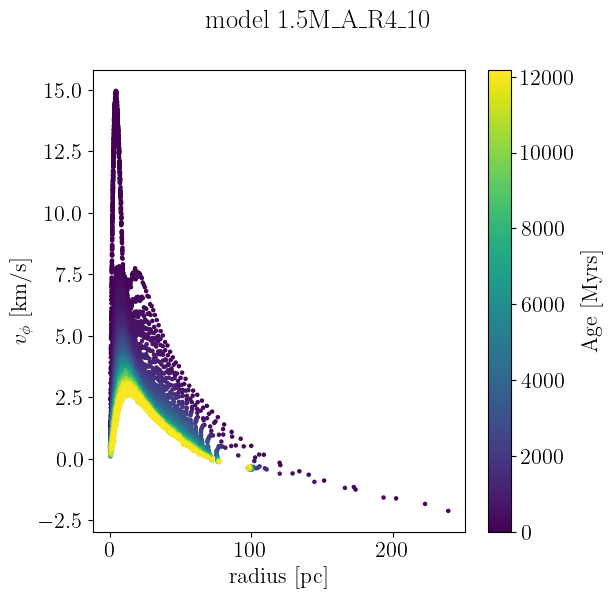

In [ ]:
m = data_1["m"]
s_phi = data_1["disp_phi"]
v_phi = data_1["v_phi"]
age = data_1["age"].flatten()  # shape (N_rows,)
print('r -', r.shape)
print('s_phi -', s_phi.shape)
print('v_phi -', v_phi.shape)
print('age -', age.shape)


# Select every 100th snapshot using list comprehension
selected_indices = range(0, len(r), 100)
r_all = np.concatenate([r[idx] for idx in selected_indices])
s_phi_all = np.concatenate([s_phi[idx] for idx in selected_indices])
v_phi_all = np.concatenate([v_phi[idx] for idx in selected_indices])
age_all = np.concatenate([np.full_like(r[idx], age[idx]) for idx in selected_indices])

# Plot1
fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle("model " + models[i])
sc = ax.scatter(r_all, v_phi_all, c=age_all, cmap='viridis', s=5)
cbar = plt.colorbar(sc)
cbar.set_label("Age [Myrs]")
ax.set_xlabel("radius [pc]")
ax.set_ylabel(r"$v_\phi$ [km/s]")
plt.show()

(750,)


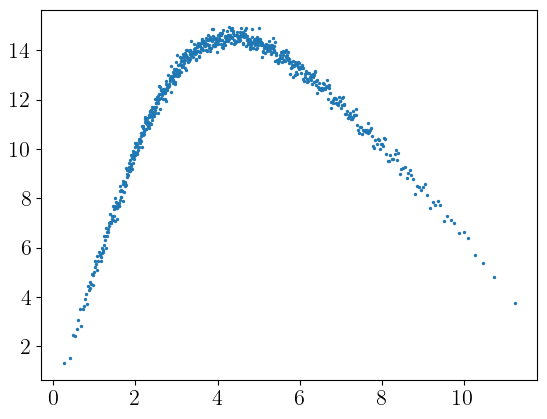

In [13]:
r_t0 = r[0]
v_phi_t0 = v_phi[0]
#r_t0 /= np.max(r_t0)
#v_phi_t0 /= np.max(v_phi_t0)
print(r_t0.shape)
plt.scatter(r_t0, v_phi_t0, s=2)
plt.show()

In [ ]:
# Seed
seed =42
np.random.seed(seed)
torch.manual_seed(seed)

X = r_t0[np.newaxis,:]
y = v_phi_t0
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = False,
                                           do_save   = True, )
# Running SR task
expression, logs = physo.SR(X, y, epochs = 20, X_units=[[1,0,0]], y_units=[1,-1,0],
                           free_consts_units=[[0,0,1], [1,0,0], [1,-1,0]],
                           fixed_consts_units=[[3,-2,-1]], fixed_consts=[6.67430*1e-11],
                           )
best_expr = expression
print(best_expr.get_infix_pretty())
sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)[0]
print(sympy_expr)
print(best_expr.get_infix_sympy(evaluate_consts=True)[0])

In [ ]:
# Get the variables from the sympy expression
variables = list(sympy_expr.free_symbols)

# Convert sympy expression to a numpy-compatible function
f = lambdify(variables, sympy_expr, 'numpy')

# Create x values for plotting
x = np.linspace(start=0, stop=15, num=1000)  # Adjust range as needed

# Calculate y values
y = f(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='SR results')
plt.scatter(r_t0, v_phi_t0, s=2, color='orange', label='data')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Expression Plot')
plt.show()

In [ ]:
r_t0 = r[0]
v_phi_t0 = v_phi[0]
r_t0 /= np.max(r_t0)
v_phi_t0 /= np.max(v_phi_t0)
print(r_t0.shape)
plt.scatter(r_t0, v_phi_t0, s=2)
plt.show()

In [ ]:
# Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
X = r_t0[np.newaxis,:]
y = v_phi_t0

save_path_training_curves = 'demo_curves_norm.png'
save_path_log             = 'demo_norm.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = False,
                                           do_save   = True, )

# Running SR task
expression, logs = physo.SR(X, y, epochs = 30, X_units=[[1,0,0]], y_units=[1,-1,0],
                           free_consts_units=[[0,0,1], [1,0,0], [1,-1,0]],
                           free_consts_names=['M', 'rs', 'vc'],
                           fixed_consts_units=[[3,-2,-1]], 
                           fixed_consts=[6.67430*1e-11],
                           op_names=['mul', 'add', 'sub','div', 'inv', 'n2', 'sqrt', 'neg', 'exp', 'log'])


best_expr = expression
print(best_expr.get_infix_pretty())
sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)[0]
print(sympy_expr)
best_expr.get_infix_sympy(evaluate_consts=True)[0]

In [ ]:
# Get the variables from the sympy expression
variables = list(sympy_expr.free_symbols)

# Convert sympy expression to a numpy-compatible function
f = lambdify(variables, sympy_expr, 'numpy')

# Create x values for plotting
x = np.linspace(start=0, stop=1, num=1000)  # Adjust range as needed

# Calculate y values
y = f(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='SR results')
plt.scatter(r_t0, v_phi_t0, s=2, color='orange', label='data')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Expression Plot')
plt.show()

In [ ]:
def populate_boundaries(r_t0, v_phi_t0, num_points=20, split_ratio=0.5, num_bins=100, sigma_multiplier=1, inner_boundary=5, outer_boundary=40):
    """Function to add points to the two extremes of the dataset to help SR learn better.
    We calculate the mean and std of the v_phi and r values in each r_bin and then sample points from a normal distribution
    at the two extremes (inner and outer radii) and add them to the dataset.
    We add points to each extremum using the split_ratio to determine how many points to add to each side.
    Parameters:
    -----------
    r_t0 : np.array
        Array of radial positions at time t0.
    v_phi_t0 : np.array
        Array of radial velocities at time t0.
    num_points : int
        Total number of points to add to the dataset.
    split_ratio : float
        Ratio of points to add to the inner extremum (0 < split_ratio < 1).
    num_bins : int
        Number of bins to use for calculating mean and std.
    sigma_multiplier : float
        Multiplier for the standard deviation when sampling new points.
    inner_boundary : int
        Number of bins to consider for the inner boundary.
    outer_boundary : int
        Number of bins to consider for the outer boundary.
    Returns:
    --------
    r_t0_augmented : np.array
        Augmented array of radial positions.
    v_phi_t0_augmented : np.array
        Augmented array of radial velocities.
    """
    # Bin points in radial bins
    hs, bins = np.histogram(r_t0, bins=num_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_indices = np.digitize(r_t0, bins) - 1  # Get bin indices for each r_t0 point
    
    # calculate v_phi mean and std in each bin 
    v_phi_means = np.array([v_phi_t0[bin_indices == i].mean() if np.any(bin_indices == i) else 0 for i in range(len(bins)-1)])
    v_phi_stds = np.array([v_phi_t0[bin_indices == i].std() if np.any(bin_indices == i) else 0 for i in range(len(bins)-1)])
    # calculate r mean and std in each bin
    r_means = np.array([r_t0[bin_indices == i].mean() if np.any(bin_indices == i) else 0 for i in range(len(bins)-1)])
    r_stds = np.array([r_t0[bin_indices == i].std() if np.any(bin_indices == i) else 0 for i in range(len(bins)-1)])    
    
    # Sample points from normal distribution at the two extremes
    num_points_inner = int(num_points * split_ratio)
    num_points_outer = num_points - num_points_inner
    print('num_points_inner:', num_points_inner)
    print('num_points_outer:', num_points_outer)

    r_inner_samples = np.array([])
    v_phi_inner_samples = np.array([])
    r_outer_samples = np.array([])
    v_phi_outer_samples = np.array([])
    for i in range(inner_boundary):
        if r_stds[i] == 0:
            r_stds[i] = 0.01 * r_means[i]
        if v_phi_stds[i] == 0:
            v_phi_stds[i] = 0.01 * v_phi_means[i]
        r_inner_samples = np.concatenate([r_inner_samples, np.random.normal(loc=r_means[i], scale=sigma_multiplier*r_stds[i], size=num_points_inner//inner_boundary)])
        v_phi_inner_samples = np.concatenate([v_phi_inner_samples, np.random.normal(loc=v_phi_means[i], scale=sigma_multiplier*v_phi_stds[i], size=num_points_inner//inner_boundary)])

    for i in range(outer_boundary):
        if r_stds[-(i+1)] == 0:
            r_stds[-(i+1)] = 0.01 * r_means[-(i+1)]
        if v_phi_stds[-(i+1)] == 0:
            v_phi_stds[-(i+1)] = 0.01 * v_phi_means[-(i+1)]
        r_outer_samples = np.concatenate([r_outer_samples, np.random.normal(loc=r_means[-(i+1)], scale=sigma_multiplier*r_stds[-(i+1)], size=num_points_outer//outer_boundary)])
        v_phi_outer_samples = np.concatenate([v_phi_outer_samples, np.random.normal(loc=v_phi_means[-(i+1)], scale=sigma_multiplier*v_phi_stds[-(i+1)], size=num_points_outer//outer_boundary)])

    # Combine the new samples with the original data
    r_t0_augmented = np.concatenate([r_t0, r_inner_samples, r_outer_samples])
    v_phi_t0_augmented = np.concatenate([v_phi_t0, v_phi_inner_samples, v_phi_outer_samples])

    return r_t0_augmented, v_phi_t0_augmented

In [ ]:
# Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
X = r_t0
y = v_phi_t0
plt.scatter(X, y, s=2, label='Original data', alpha=0.7)
X, y = populate_boundaries(X, y, num_points=100, split_ratio=0.2, num_bins=100, 
                           sigma_multiplier=1, inner_boundary=5, outer_boundary=10)
plt.scatter(X, y, s=2, label='Augmented data', alpha=0.2)
plt.legend()
plt.show()
X = X[np.newaxis,:]

In [ ]:
# Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
save_path_training_curves = 'demo_curves_norm.png'
save_path_log             = 'demo_norm.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = False,
                                           do_save   = True, )

# Running SR task
expression, logs = physo.SR(X, y, epochs = 40, X_units=[[1,0,0]], y_units=[1,-1,0],
                           free_consts_units=[[0,0,1], [1,0,0], [1,-1,0]],
                           free_consts_names=['M', 'rs', 'vc'],
                           fixed_consts_units=[[3,-2,-1]], 
                           fixed_consts=[6.67430*1e-11],
                           op_names=['mul', 'add', 'sub','div', 'inv', 'n2', 'sqrt', 'neg', 'exp', 'log'])


best_expr = expression
print(best_expr.get_infix_pretty())
sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)[0]
print(sympy_expr)
best_expr.get_infix_sympy(evaluate_consts=True)[0]

In [ ]:
# Get the variables from the sympy expression
variables = list(sympy_expr.free_symbols)

# Convert sympy expression to a numpy-compatible function
f = lambdify(variables, sympy_expr, 'numpy')

# Create x values for plotting
x = np.linspace(start=0, stop=1, num=1000)  # Adjust range as needed

# Calculate y values
y = f(x)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='SR results')
plt.scatter(r_t0, v_phi_t0, s=2, color='orange', label='data')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Expression Plot')
plt.show()

In [ ]:
T = 10
X = []
y = []
for i in range(T):
    r_temp = copy.deepcopy(r[i])
    v_phi_temp = copy.deepcopy(v_phi[i])
    t = np.full_like(r_temp, fill_value=age[i])
    x = np.stack([t, r_temp], axis=0)
    X.append(x)
    y.append(v_phi_temp)
X = np.concatenate(X, axis=1)
y = np.concatenate(y)
print(X.shape)  
print(y.shape)


In [ ]:
indices = np.where(np.isnan(X))[1]
X = np.delete(X, indices, axis=1) # delete the entire row
y = np.delete(y, indices)
print(X.shape)
print(y.shape)

In [ ]:
# Seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

save_path_training_curves = 'demo_curves_norm_multiT.png'
save_path_log             = 'demo_norm_multiT.log'

run_logger     = lambda : monitoring.RunLogger(save_path = save_path_log,
                                                do_save = True)

run_visualiser = lambda : monitoring.RunVisualiser (epoch_refresh_rate = 1,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = False,
                                           do_save   = True, )

# Running SR task
expression, logs = physo.SR(X, y, epochs = 30, X_units=[[0,1,0],[1,0,0]], X_names=["t", "r"], 
                           y_units=[1,-1,0], y_name='vr', 
                           free_consts_units=[[0,0,1], [1,0,0], [1,-1,0], [0,1,0]],
                           free_consts_names=['M', 'rs', 'vc', 'T'],
                           fixed_consts_units=[[3,-2,-1]], 
                           fixed_consts=[6.67430*1e-11],
                           op_names=['mul', 'add', 'sub','div', 'inv', 'n2', 'sqrt', 'neg', 'exp', 'log'],
                           run_config = physo.config.config2.config2)


best_expr = expression
print(best_expr.get_infix_pretty())
sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)[0]
print(sympy_expr)
best_expr.get_infix_sympy(evaluate_consts=True)[0]

In [ ]:
# Get the variables from the sympy expression
variables = list(sympy_expr.free_symbols)
print("Variables: ", variables)
# Convert sympy expression to a numpy-compatible function
f = lambdify(variables, sympy_expr, 'numpy')

# Create x values for plotting
x = np.linspace(start=0, stop=80, num=1000)  # Adjust range as needed
tt = np.array([])
xx = np.array([])
for i in range(10):
    r_temp = copy.deepcopy(x)
    t_temp = np.full_like(r_temp, fill_value=age[i])
    tt = np.concatenate([tt, t_temp])
    xx = np.concatenate([xx, r_temp])

# Calculate y values
y_plot = f(xx)
r_plot = xx
print(r_plot.shape)
print(y_plot.shape)

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(r_plot, y_plot, s=2, label='SR results')
plt.scatter(X[1,:], y, s=2, color='orange', label='data')
plt.legend()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Expression Plot')
plt.show()

In [ ]:
# Multi class SR with t as a model/class parameter
X = 